![image](https://docs.google.com/uc?export=download&id=1Nh6vjig-ADM1RMbaHrj_GItD3O1ZW4Vr)

<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/jpcano1/MINE_4206_Analisis_con_Machine_Learning/blob/main/Lab%20VI/Lab_VI.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </td>
</table>

# **Taller No. 6**
## **Visión por Computador y Perceptrón Multicapa**

## **Objetivos**
- Introducción a la extracción de características en imágenes
- Entrenamiento con redes neuronales profundas.
- Tuneo de hiperparámetros en redes neuronales.

## **Nombres de los Integrantes**
- **Integrante 1:**
- **Integrante 2:**
- **Integrante 3:**

## **Problema 1**
- Los peligros asociados a la minería de carbón son bastantes, desde enfermedades pulmonares hasta explosiones por combustión. Sin embargo, uno bastante común es el peligro sísmico. Los peligros sísmicos se resumen como la probabilidad de que un terremoto vaya a ocurrir en un área geográfica determinada. Por lo que, se le ha asignado la tarea de predecir la posibilidad de que un peligro sísmico ocurra en un área específica dadas sus condiciones geográficas.



In [ ]:
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
import setup_colab_general as setup_general
setup_general.setup_general()


General Functions Enabled Successfully


## **Importando las librerías necesarias para el laboratorio**

In [ ]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

import utils.general as gen

from skimage import io, color, exposure, feature

from sklearn.model_selection import RandomizedSearchCV

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tqdm.auto import tqdm

In [ ]:
data_id = "10pDfpxFAXkBGD29CfZQ7RaoIFMyyKpAI"

In [ ]:
gen.download_file_from_google_drive(data_id, "alzheimer.zip", size=36050)


Deleting File...


In [ ]:
train_set_dir = gen.create_and_verify(
    "data", "Alzheimer_s Dataset", 
    "train", list_=True
)

In [ ]:
train_set_dir

array(['data/Alzheimer_s Dataset/train/MildDemented',
       'data/Alzheimer_s Dataset/train/ModerateDemented',
       'data/Alzheimer_s Dataset/train/NonDemented',
       'data/Alzheimer_s Dataset/train/VeryMildDemented'], dtype='<U47')

In [ ]:
train_set_counts = {
    "Label": [
        "Mild Demented",
        "Moderate Demented",
        "Non Demented",
        "Very Mild Demented"
    ],
    "Counts": [
        len(gen.read_listdir(train_set_dir[0])),
        len(gen.read_listdir(train_set_dir[1])),
        len(gen.read_listdir(train_set_dir[2])),
        len(gen.read_listdir(train_set_dir[3]))
    ]
}

train_set_counts = pd.DataFrame(train_set_counts)

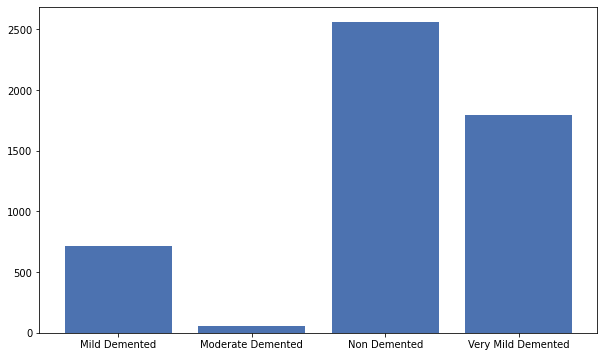

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x=train_set_counts["Label"], height=train_set_counts["Counts"])
plt.show()

## **Visualización y Análisis**

In [ ]:
data_dirs = []

for dir_ in train_set_dir:
    data_dirs.extend(gen.read_listdir(dir_))
data_dirs = np.array(data_dirs)

In [ ]:
data_dirs

array(['data/Alzheimer_s Dataset/train/MildDemented/mildDem0.jpg',
       'data/Alzheimer_s Dataset/train/MildDemented/mildDem1.jpg',
       'data/Alzheimer_s Dataset/train/MildDemented/mildDem10.jpg', ...,
       'data/Alzheimer_s Dataset/train/VeryMildDemented/verymildDem997.jpg',
       'data/Alzheimer_s Dataset/train/VeryMildDemented/verymildDem998.jpg',
       'data/Alzheimer_s Dataset/train/VeryMildDemented/verymildDem999.jpg'],
      dtype='<U67')

In [ ]:
np.random.seed(1234)
train_dirs = np.random.choice(data_dirs, size=len(data_dirs) * 80 // 100)
val_dirs = np.array([x for x in data_dirs if x not in train_dirs])

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data_dirs, hog=False):
        self.n = 0
        self.data_dirs = data_dirs
        self.label_map = {
            "MildDemented": 0,
            "ModerateDemented": 0,
            "NonDemented": 1,
            "VeryMildDemented": 2
        }
        self.hog = hog
    
    def __len__(self):
        return len(self.data_dirs)
    
    def size(self):
        return len(self)
    
    def __getitem__(self, idx):
        img_dir = self.data_dirs[idx]
        img = color.rgb2gray(io.imread(img_dir))
        if self.hog:
            img = feature.hog(img, multichannel=False)
        label = img_dir.split(os.path.sep)[-2]
        label = self.label_map[label]
        return img, label

In [ ]:
train_generator = DataGenerator(train_dirs)
val_generator = DataGenerator(val_dirs)

In [ ]:
np.random.seed(1234)
random_sample = np.random.choice(range(len(train_generator)), 9)
random_sample

array([2863,  723, 1318, 3125, 3276, 3444,  664, 2041, 3727])

In [ ]:
imgs = []
labels = []

for i in random_sample:
    img, label = train_generator[i]
    imgs.append(img)
    labels.append(label)

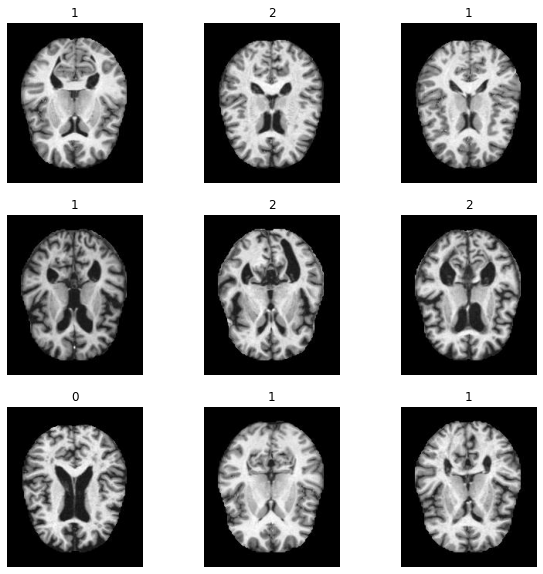

In [ ]:
gen.visualize_subplot(imgs, labels, (3, 3), figsize=(10, 10))

## **Separación y Procesamiento**
### **Histograma de Gradientes Orientados**
![image](https://docs.google.com/uc?export=download&id=1zC8X95PdsDoUIo0KBZ390ylDAVaj48lw)
- El histograma de gradientes orientados es un algoritmo que se basa en la extracción de características morfológicas de una imagen con respecto a los gradientes (razones de cambio) en X e Y que se presenten a lo largo de los objetos presentes en ella.
> *Computer Vision: Algorithms and Applications.* R. Szeliski. Springer, 2011.

- Con qué objetivo se hace lo anterior? Extraer contornos, siluetas e información de las texturas.

In [ ]:
imgs_hog = []
for img in imgs:
    _, img_hog = feature.hog(img, visualize=True, multichannel=False)
    imgs_hog.append(img_hog)

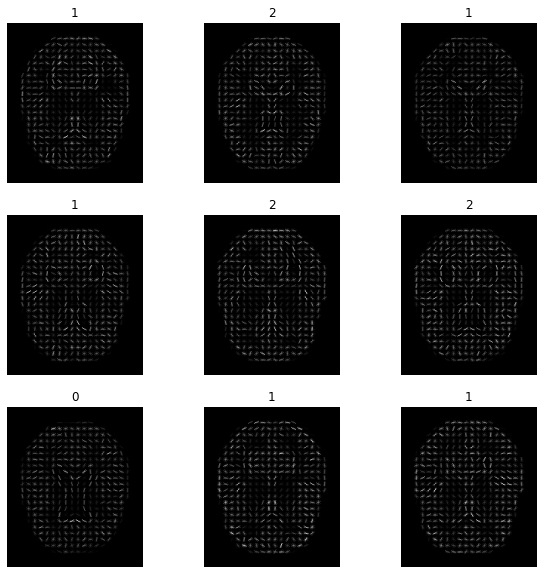

In [ ]:
gen.visualize_subplot(imgs_hog, labels, (3, 3), figsize=(10, 10))

In [ ]:
train_generator = DataGenerator(train_dirs, hog=True)
val_generator = DataGenerator(val_dirs, hog=True)

In [ ]:
X_train = []
y_train = []

for img, label in tqdm(train_generator):
    X_train.append(img)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_val = []
y_val = []

for img, label in tqdm(val_generator):
    X_val.append(img)
    y_val.append(label)

X_val = np.array(X_val)
y_val = np.array(y_val)

In [ ]:
X_train.shape

(4096, 38880)

## **Modelado**

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(3, activation="softmax")
])

In [ ]:
model.compile(
    optimizer="adam", 
    loss=keras.losses.SparseCategoricalCrossentropy(name="loss"), 
    metrics=["acc"]
)

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=20, validation_data=(X_val, y_val),
    batch_size=32
)

Epoch 1/20
128/128 [==============================] - 4s 10ms/step - loss: 0.9588 - acc: 0.5588 - val_loss: 0.7102 - val_acc: 0.7250
Epoch 2/20
128/128 [==============================] - 1s 6ms/step - loss: 0.4987 - acc: 0.8169 - val_loss: 0.7302 - val_acc: 0.6329
Epoch 3/20
128/128 [==============================] - 1s 6ms/step - loss: 0.2981 - acc: 0.9082 - val_loss: 0.3999 - val_acc: 0.8431
Epoch 4/20
128/128 [==============================] - 1s 6ms/step - loss: 0.2067 - acc: 0.9309 - val_loss: 0.3462 - val_acc: 0.8673
Epoch 5/20
128/128 [==============================] - 1s 6ms/step - loss: 0.0991 - acc: 0.9826 - val_loss: 0.3286 - val_acc: 0.8733
Epoch 6/20
128/128 [==============================] - 1s 6ms/step - loss: 0.0629 - acc: 0.9908 - val_loss: 0.3548 - val_acc: 0.8608
Epoch 7/20
128/128 [==============================] - 1s 6ms/step - loss: 0.0352 - acc: 0.9974 - val_loss: 0.2888 - val_acc: 0.8975
Epoch 8/20
128/128 [==============================] - 1s 6ms/step - loss: 0

In [ ]:
history = pd.DataFrame(history.history)

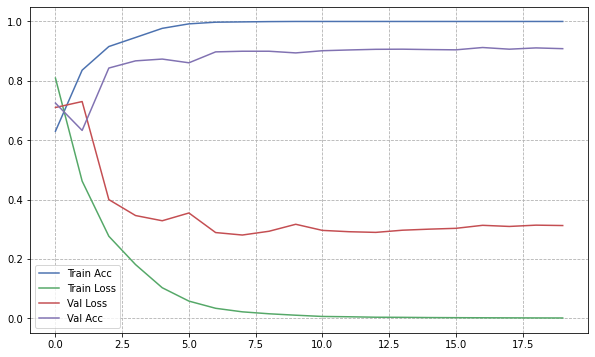

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(history["acc"], label="Train Acc")
plt.plot(history["loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend(loc="best")
plt.grid(linestyle="--")
plt.show()

* Modelado (Keras, Perceptrón Multicapa).
* Otro Dataset.
* Random Search Tuneo de Hiperparámetros. Función de Activación y Número de Epochs, número de neuronas por capas, 2 capas.

In [ ]:
def build_model(activation="relu", units=32):
    model = keras.Sequential([
        keras.layers.Dense(
            units * 2, activation=activation, 
            kernel_initializer="he_normal"
        ),
        keras.layers.Dense(
            units, activation=activation, 
            kernel_initializer="he_normal"
        ),
        keras.layers.Dense(3, activation="softmax")
    ])

    loss = keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer="adam", loss=loss, metrics=["acc"])
    return model

In [ ]:
model = KerasClassifier(build_fn=build_model, batch_size=32)

In [ ]:
param_grid = {
    "epochs": [5, 10],
    "activation": ["relu", "selu", "elu"],
    "units": [64, 128]
}

In [ ]:
random_search = RandomizedSearchCV(model, param_grid)

In [ ]:
random_search.fit(X_train, y_train)

Epoch 1/10
103/103 [==============================] - 1s 5ms/step - loss: 2.6379 - acc: 0.4725
Epoch 2/10
103/103 [==============================] - 1s 5ms/step - loss: 0.7349 - acc: 0.6792
Epoch 3/10
103/103 [==============================] - 1s 5ms/step - loss: 0.5050 - acc: 0.8156
Epoch 4/10
103/103 [==============================] - 1s 5ms/step - loss: 0.3593 - acc: 0.8635
Epoch 5/10
103/103 [==============================] - 1s 5ms/step - loss: 0.1737 - acc: 0.9480
Epoch 6/10
103/103 [==============================] - 1s 5ms/step - loss: 0.1068 - acc: 0.9729
Epoch 7/10
103/103 [==============================] - 1s 5ms/step - loss: 0.0605 - acc: 0.9889
Epoch 8/10
103/103 [==============================] - 0s 5ms/step - loss: 0.0267 - acc: 0.9983
Epoch 9/10
103/103 [==============================] - 0s 5ms/step - loss: 0.0206 - acc: 0.9971
Epoch 10/10
26/26 [==============================] - 0s 4ms/step - loss: 0.1445 - acc: 0.9549
Epoch 1/10
103/103 [==============================]

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f7a507554d0>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'activation': ['relu', 'selu', 'elu'],
                                        'epochs': [5, 10], 'units': [64, 128]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [ ]:
print(f"Mejor puntaje: {random_search.best_score_} usando {random_search.best_params_}")

Mejor puntaje: 0.9509267687797547 usando {'units': 64, 'epochs': 10, 'activation': 'elu'}


## **Validación**